In [ ]:
# !pip install numpy matplotlib cvxopt pandas yfinance finquant plotly cufflinks chart_studio pandas_datareader atoti atoti-jupyterlab

In [ ]:
%matplotlib inline
import random

import cvxopt as opt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from cvxopt import blas, solvers
from finquant.portfolio import build_portfolio
from scipy.optimize import minimize
import pandas_datareader.data as web
import contextlib

np.random.seed(123)

# Turn off progress printing
solvers.options["show_progress"] = False
import concurrent.futures
import os
import random
import urllib
import urllib.request
from concurrent.futures import ALL_COMPLETED, wait

import atoti as tt
import cufflinks
import numpy as np
import pandas_market_calendars as mcal

# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py

# (*) Useful Python/Plotly tools
import plotly.tools as tls

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

In [ ]:
# ndays = 252*10+7
ndays = 252 * 1.5 + 7
# ~training
dback = 252
# ~forecast
dahead = 20
# sample size
# if to randomize
rand = True
nran = 20
nstocks = 100
# this should match tbill 20, 91, 126, 252

end = pd.Timestamp.utcnow()
start = end - int(ndays) * pd.tseries.offsets.BDay()
one_week_end = end - int(ndays - 7) * pd.tseries.offsets.BDay()
one_week_end = one_week_end.strftime("%Y-%m-%d")
start = start.strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")

In [ ]:
# pd.tseries.offsets.BDay(100)
nyse = mcal.get_calendar("NYSE")

# Show available calendars
# print(mcal.get_calendar_names())
tradingDays = list(
    nyse.schedule(start_date=start, end_date=end).index.strftime("%Y-%m-%d")
)

In [179]:
def rand_weights(n):
    """ Produces n random weights that sum to 1 """
    k = np.random.rand(n)
    return k / sum(k)


def weighted_return(returns, weights):
    w = weights

    p = np.asmatrix(np.mean(returns, axis=0))

    mu = np.asmatrix(w) * p.T
    return mu


def random_portfolio(TREASURY_BILL_RATE,returns):

    w = rand_weights(len(pd.DataFrame(returns).columns))

    p = np.asmatrix(np.mean(returns, axis=0))

    C = np.array(pd.DataFrame(returns).cov().values)

    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)

    sharpe = (mu-TREASURY_BILL_RATE)/sigma
    #sharpe = mu / sigma

    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w, dtype=object)


def unique(list1):

    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list


def split_sequences(sequences, n_steps_in, n_steps_out):

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
url = "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt"

urllib.request.urlretrieve(url, "nasdaqtraded.txt")
urllib.request.urlretrieve(url, "mfundslist.txt")
urllib.request.urlretrieve(url, "bonds.txt")

df1 = pd.read_csv("nasdaqtraded.txt", sep="|")[0:-1]
df2 = pd.read_csv("mfundslist.txt", sep="|")[0:-1]
df3 = pd.read_csv("bonds.txt", sep="|")[0:-1]

# combined = pd.concat([df1['Symbol'],df2['Symbol'],df3['Symbol']],axis=0)

# process symbols for bad characters
BAD_CHARS = ["$", "."]
# pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])
# cleaned = unique(combined.replace(BAD_CHARS,'-'))

# choose size
size = nstocks
# stocks = list(df1["Symbol"].sample(n=int(size/3)))
stocks = list(
    df1["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
mfunds = list(
    df2["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
bonds = list(
    df3["Symbol"]
    .replace(".", "-")
    .replace("\\$", "-P", regex=True)
    .sample(n=int(size / 3))
)
symbols = list(set(stocks + mfunds + bonds))  # unique(stocks + mfunds + bonds)
# symbols = unique(stocks)

In [ ]:
print(start, one_week_end)

In [ ]:
pf_pre = build_portfolio(
    names=symbols, start_date=start, end_date=one_week_end, data_api="yfinance"
)

In [ ]:
vetted_symbols = list(
    pf_pre.data.loc[
        (np.intersect1d(list(pf_pre.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .tail(-1)
    .dropna(axis=1)
    .columns
)

In [ ]:
# combinedList = unique(list(np.append(random.sample(symbols_sp500,int(len(symbols_sp500)*.05)),np.append(random.sample(dividendAristocraft,int(len(dividendAristocraft)*.25)),np.append(top10,random.sample(symbols_ns100,int(len(symbols_ns100)*.25)))))))

# add index
# vetted_symbols.append('TQQQ')

pf = build_portfolio(
    names=list(vetted_symbols), start_date=start, end_date=end, data_api="yfinance"
)

In [ ]:
"""
import pandas_datareader.data as web

import datetime

# Multiple series:
fred_data = web.DataReader(FRED_Indicators, 'fred', start, end)
"""

FRED_Indicators = ["DTB4WK", "DTB3", "DTB6", "DTB1YR"]

def Fred_Data(name):
    temp = web.DataReader(str(name), "fred", start, end)
    temp.index = pd.to_datetime(temp.index)
    # temp = temp.resample(frequency).mean().dropna()
    return temp


FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))

FRED_pvt = pd.DataFrame()

for x in range(0, len(FRED_completed)):
    values = FRED_set[x]
    values = values.loc[~values.index.duplicated(keep="last")]

    FRED_pvt = pd.concat([FRED_pvt, values], axis=1)

In [ ]:
returns = np.log(
    1
    + pf.data.loc[
        (np.intersect1d(list(pf.data.index.strftime("%Y-%m-%d")), tradingDays))
    ]
    .head(-1)
    .interpolate(method="time")
    .pct_change()
    .tail(-1)
)
returns = returns.dropna(axis=1)
# returns.columns = stocks.dropna(axis=1)
len(returns.columns)
# np.sum(returns.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)

In [ ]:
selectedmfunds = set(mfunds) & set(returns.columns)
selectedstocks = set(stocks) & set(returns.columns)
selectedbonds = set(bonds) & set(returns.columns)

In [ ]:
n_steps_in = dback

n_steps_out = dahead

Training, Holdout = split_sequences(
    np.array(pd.DataFrame(returns.index.strftime("%Y-%m-%d"))), n_steps_in, n_steps_out
)

In [ ]:
FRED_pvt.columns

,DTB4WK,DTB3,DTB6,DTB1YR
DATE,,,,
2020-05-21,0.090,0.12,0.140,0.16
2020-05-22,0.090,0.12,0.160,0.17
2020-05-25,0.095,0.13,0.165,0.17
2020-05-26,0.100,0.14,0.170,0.17
2020-05-27,0.100,0.15,0.170,0.18
...,...,...,...,...
2021-11-03,0.050,0.05,0.070,0.17
2021-11-04,0.050,0.04,0.070,0.14
2021-11-05,0.050,0.05,0.070,0.14


In [ ]:
#stocks.melt(ignore_index=False)
prices = returns.melt(ignore_index=False).reset_index()

In [ ]:
session = tt.create_session(config={"user_content_storage": "./content"})

In [ ]:
prices_table = session.read_pandas(
    prices,
    keys=["Date", "variable"],
    table_name="prices",
)
#prices_table.head()

cube = session.create_cube(prices_table)

In [ ]:
cube.schema

In [ ]:
session.visualize()

In [ ]:
h = cube.hierarchies
l = cube.levels
m = cube.measures

In [ ]:
l

In [ ]:
m

In [ ]:
cube.query(m["contributors.COUNT"])

In [ ]:
#display(cube.query(m["value.SUM"], levels=[l["Date"]]))

display(cube.query(m["value.MEAN"], levels=[l["variable"]]))

<AxesSubplot:xlabel='DATE'>

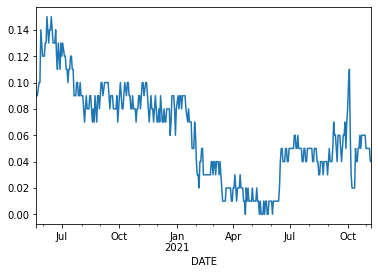

In [187]:
FRED_pvt['DTB4WK'].interpolate().plot()

In [188]:
#m["Lookback Window"] = 252

n_portfolio = 100

stocksp = 0.2
mfundsp = 0.1
bondsp = 0.2
commp = 0.2


#simulation

randomSet = list(np.sort(np.random.choice(range(0, len(Training)), nran)))

for tensor in randomSet:

    bestSharpe = 0
    runs = 0
    weight = None
    bestMean = 0
    bestStd = 0
    means = np.array([])
    stds = np.array([])
    sharpes = np.array([])
    bestWeights = None
    weights = np.array([])
    
    names = Training_query.T.columns

    randomsymbols = list(np.random.choice(pf.data.columns, 10, replace=False))
    
    Training_dates = list(Training[tensor].ravel())
    
    TREASURY_BILL_RATE =  FRED_pvt.interpolate()[FRED_pvt.index==Training_dates[-1]]['DTB4WK'].dropna().values[-1]
    print(TREASURY_BILL_RATE)
    
    Holdout_dates = list(Holdout[tensor].ravel())
    
    Training_query = \
    (
        cube.query(
            m["value.MEAN"],
            levels=[l["variable"]],
            condition=(
            (l["variable"].isin(*randomsymbols))
            & (l["Date"].isin(*Training_dates))
            ),
        )
    )
    
    Holdout_query = \
    (
        cube.query(
            m["value.MEAN"],
            levels=[l["variable"]],
            condition=(
            (l["variable"].isin(*randomsymbols))
            & (l["Date"].isin(*Holdout_dates))
            ),
        )
    )
    
    #display([dates[0],dates[-1]])
    #display(query.T)
    
    #Monte Carlo efficient frontier
    for _ in range(n_portfolio):
        means2, stds2, sharpes2, weights2 = np.column_stack(
            [random_portfolio((TREASURY_BILL_RATE*1/252.75),Training_query.T) for _ in range(len(Training_query.T.columns))]
        )
        means_ = means2
        stds_ = stds2
        sharpes_ = sharpes2
        weights_ = weights2

        bestWeights = weights_[sharpes_.argmax()]

        means = np.append(means, means_)
        stds = np.append(stds, stds_)
        sharpes = np.append(sharpes, sharpes_)
        weights = np.append(weights, weights_)

    df_ = pd.DataFrame(weights[sharpes.argmax()]).set_index(Training_query.T.columns)
    df_.columns = ["Weights"]

    #next4weeks = returns.loc[[i[0] for i in Holdout[tensor]]][randomsymbols]

    df_.sort_values(by=["Weights"], ascending=False, inplace=True)

    wr = np.array(
        weighted_return(
            np.array((np.exp(Holdout_query.T) - 1).cumsum().tail(1)),
            weights[sharpes.argmax()],
        )
    )[0][0]
    
    max_sr_ret = means[sharpes.argmax()]
    max_sr_vol = stds[sharpes.argmax()]
    max_sharpe = sharpes[sharpes.argmax()]
    
    display(Training_query.mean())    
    display(Holdout_query.mean())
    display(wr)

    #display([bestWeights, max_sr_ret, max_sr_vol, max_sharpe, wr])
    display(pd.DataFrame(bestWeights).set_index(names).T)
    #'''
    

0.01


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.00131
dtype: float64

value.MEAN   -0.003104
dtype: float64

-0.0037278764438684877

variable,CHIS,EEH,ERC,EWP,GENE,IGHG,KSU,OGS,PSC,WBND
0,0.024956,0.167265,0.012845,0.064647,0.232854,0.115217,0.233479,0.064724,0.04422,0.039794


0.01


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000689
dtype: float64

value.MEAN    0.001418
dtype: float64

0.0014744116036168695

variable,CSWI,ESTA,HOOK,IDIV,IJS,INSW,KSU,PNBK,TWM,VGR
0,0.087568,0.168711,0.079474,0.121584,0.015145,0.145862,0.13626,0.103858,0.114761,0.026778


0.01


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000402
dtype: float64

value.MEAN   -0.003046
dtype: float64

-0.0030871575940665794

variable,ACHC,CPHC,CSR,CYB,EEH,LEVI,PNBK,SMLP,TAL,UDR
0,0.056995,0.138982,0.185312,0.038285,0.134338,0.177622,0.034963,0.123076,0.021627,0.088801


0.02


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.001322
dtype: float64

value.MEAN   -0.001607
dtype: float64

-0.002256004940921934

variable,ARDX,CHIS,CME,ECF,EDIT,EWP,GLG,GVP,LKOR,TAL
0,0.157682,0.07035,0.157322,0.111414,0.015151,0.029271,0.130899,0.059885,0.170874,0.097151


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN   -0.000255
dtype: float64

value.MEAN   -0.007786
dtype: float64

-0.004456031992721991

variable,AMZN,ARDX,CHIS,CYB,FLIA,KBAL,KSU,PML,TNA,VATE
0,0.167322,0.035767,0.086291,0.14812,0.061052,0.141397,0.021324,0.103757,0.213694,0.021276


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.002157
dtype: float64

value.MEAN   -0.001922
dtype: float64

-0.002535739263991021

variable,APRE,ARMK,BSTZ,ECF,JTD,LKOR,PGX,TAL,UDR,ULTR
0,0.201051,0.050246,0.041909,0.046512,0.013029,0.068917,0.17645,0.151837,0.120654,0.129394


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000205
dtype: float64

value.MEAN   -0.000271
dtype: float64

-0.0003852520084721414

variable,ACHC,AGO,AMZN,APEI,ARMK,BHFAP,CHIS,ESTA,KBAL,LEVI
0,0.158365,0.068943,0.153725,0.118307,0.122454,0.056001,0.121154,0.028986,0.072399,0.099666


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000264
dtype: float64

value.MEAN    0.000194
dtype: float64

-0.0004863453274436741

variable,BAC-PB,CHIS,ENR-PA,ERC,HOOK,PGX,PNBK,SMM,TWM,VCRA
0,0.049146,0.120124,0.040061,0.220484,0.06311,0.113198,0.075657,0.133267,0.101036,0.083918


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000843
dtype: float64

value.MEAN    0.000757
dtype: float64

0.0015080160661934696

variable,AMZN,EEH,FLIA,IBHB,IGHG,MSA,PML,TWM,ULTR,VCRA
0,0.065724,0.146362,0.027319,0.033207,0.179361,0.084851,0.023903,0.046727,0.174498,0.218049


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN   -0.000913
dtype: float64

value.MEAN   -0.003406
dtype: float64

-0.0025708326102860174

variable,ABB,APEI,ARMK,BHFAP,IBHB,IGHG,INSW,JTD,MSA,VGR
0,0.125042,0.003305,0.091225,0.14385,0.028366,0.082194,0.122067,0.160382,0.103812,0.139756


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000903
dtype: float64

value.MEAN   -0.001251
dtype: float64

-0.0025521921169608577

variable,AGQ,APRE,ENR-PA,IJS,PRDO,SMLP,TAL,UDR,VGR,WBND
0,0.146888,0.10519,0.155738,0.03896,0.043011,0.043257,0.163826,0.090021,0.049366,0.163743


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000783
dtype: float64

value.MEAN   -0.000467
dtype: float64

-0.00036409566820770904

variable,APEI,CHIS,CPHC,ESTA,HOOK,IGHG,INSW,PMAR,TTAI,VCRA
0,0.160069,0.117328,0.015703,0.160286,0.039151,0.165605,0.050528,0.165274,0.075216,0.050838


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000465
dtype: float64

value.MEAN   -0.000309
dtype: float64

4.341452165569306e-05

variable,CYB,ERC,FUN,GVP,IJS,KSU,OGS,SMM,TTAI,TWM
0,0.109109,0.090687,0.151246,0.136734,0.080554,0.061651,0.068288,0.019961,0.111124,0.170647


0.03


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.0001
dtype: float64

value.MEAN    0.002204
dtype: float64

0.002334710406608449

variable,EEH,ERC,GLG,KBAL,LKOR,MGNI,MSA,OGS,PMAR,SMM
0,0.048353,0.185427,0.073626,0.149316,0.03992,0.078193,0.163176,0.14976,0.040053,0.072176


0.04


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000946
dtype: float64

value.MEAN   -0.000125
dtype: float64

-0.00010443334102768842

variable,APRE,BSTZ,CME,EEH,GVP,JTD,KSU,PMAR,SMM,ULTR
0,0.002147,0.118026,0.131172,0.233544,0.015836,0.061973,0.066084,0.07472,0.193659,0.10284


0.06


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000086
dtype: float64

value.MEAN    0.000184
dtype: float64

5.7475497775707854e-05

variable,CYB,ECF,EEH,FLIA,IJS,IXP,KBAL,TTAI,VATE,VGR
0,0.095134,0.081527,0.182253,0.149147,0.1586,0.077584,0.096326,0.001902,0.107813,0.049715


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000392
dtype: float64

value.MEAN    0.002404
dtype: float64

0.0026122372510204413

variable,CME,ERC,ESGY,GENE,GLG,IGHG,JTD,LEVI,PGX,ULTR
0,0.125762,0.154855,0.149226,0.075784,0.086359,0.108586,0.007546,0.014633,0.173801,0.103449


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.000864
dtype: float64

value.MEAN    0.001413
dtype: float64

0.002095474294772069

variable,AGO,ENR-PA,ESTA,GVP,IBHB,IDIV,PBTP,TAL,TTAI,UDR
0,0.14476,0.183375,0.005589,0.201763,0.061298,0.143397,0.159489,0.043598,0.028918,0.027814


0.06


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN    0.002267
dtype: float64

value.MEAN   -0.001438
dtype: float64

-0.0016569729780584548

variable,AMZN,CSWI,FUN,GENE,INSW,KSU,LEVI,LKOR,MINC,PRDO
0,0.185498,0.138502,0.002365,0.100529,0.12216,0.181684,0.000699,0.042719,0.11914,0.106705


0.05


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9525: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning:

invalid value encountered in multiply

C:\Users\User\AppData\Local\Temp/ipykernel_4384/2452458082.py:30: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\sha

value.MEAN   -0.000041
dtype: float64

value.MEAN    0.000296
dtype: float64

0.0007351429033756356

variable,ABB,ACWX,EWP,MGNI,MINC,PML,SMLP,SMM,UDR,VATE
0,0.12134,0.042425,0.05518,0.013389,0.174276,0.134871,0.066854,0.044722,0.170328,0.176615
